In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json

# diseases codes website (precise) : https://www.aapc.com/codes/icd9-codes/250.93
# diseases codes lookup table (does not contain all codes) : https://www.aafp.org/fpm/icd9/icd9-short.pdf#

# Define functions

In [14]:
def create_get_value_fn(mapping):
    def get_value(row, default_value:str = "250"):
        for val in [row['diag_1'], row['diag_2'], row['diag_3']]:
            if val in list(mapping.keys()):
                return val
        return default_value
    return get_value

# Create and display pie chart with value + percent labels
def autopct_format(values):
    def autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f'{pct:.1f}%\n({count})'
    return autopct


def do_pie_chart(data: pd.DataFrame, title: str=f'Overall readmission status repartition', column_to_count_on:str = "readmitted", counted_values:list = ['<30', '>30', 'NO']):
    # Count occurrences
    counts = data.copy()[column_to_count_on].value_counts().reindex(counted_values, fill_value=0)

    counts.plot.pie(
        labels=counts.index,
        autopct=autopct_format(counts),
        ylabel='',
        startangle=90,
        counterclock=False,
        shadow=True
    )
    plt.title(title)
    plt.show()

    return plt.gcf(), plt.gca()

# Conversion of diabetes codes

In [5]:
diabetes_precise_dict = {
    '250': "Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled (250.00)",
    '250.01': "Diabetes mellitus without mention of complication, type I [juvenile type], not stated as uncontrolled (250.01)",
    '250.02': "Diabetes mellitus without mention of complication, type II or unspecified type, uncontrolled (250.02)",
    '250.03': "Diabetes mellitus without mention of complication, type I [juvenile type], uncontrolled (250.03)",
    '250.1': "Diabetes with ketoacidosis, type II or unspecified type, not stated as uncontrolled (250.10)",
    '250.11': "Diabetes with ketoacidosis, type I [juvenile type], not stated as uncontrolled (250.11)",
    '250.12': "Diabetes with ketoacidosis, type II or unspecified type, uncontrolled (250.12)",
    '250.13': "Diabetes with ketoacidosis, type I [juvenile type], uncontrolled (250.13)",
    '250.2': "Diabetes with hyperosmolarity, type II or unspecified type, not stated as uncontrolled (250.20)",
    '250.21': "Diabetes with hyperosmolarity, type I [juvenile type], not stated as uncontrolled (250.21)",
    '250.22': "Diabetes with hyperosmolarity, type II or unspecified type, uncontrolled (250.22)",
    '250.23': "Diabetes with hyperosmolarity, type I [juvenile type], uncontrolled (250.23)",
    '250.3': "Diabetes with other coma, type II or unspecified type, not stated as uncontrolled (250.30)",
    '250.31': "Diabetes with other coma, type I [juvenile type], not stated as uncontrolled (250.31)",
    '250.32': "Diabetes with other coma, type II or unspecified type, uncontrolled (250.32)",
    '250.33': "Diabetes with other coma, type I [juvenile type], uncontrolled (250.33)",
    '250.4': "Diabetes with renal manifestations, type II or unspecified type, not stated as uncontrolled (250.40)",
    '250.41': "Diabetes with renal manifestations, type I [juvenile type], not stated as uncontrolled (250.41)",
    '250.42': "Diabetes with renal manifestations, type II or unspecified type, uncontrolled (250.42)",
    '250.43': "Diabetes with renal manifestations, type I [juvenile type], uncontrolled (250.43)",
    '250.5': "Diabetes with ophthalmic manifestations, type II or unspecified type, not stated as uncontrolled (250.50)",
    '250.51': "Diabetes with ophthalmic manifestations, type I [juvenile type], not stated as uncontrolled (250.51)",
    '250.52': "Diabetes with ophthalmic manifestations, type II or unspecified type, uncontrolled (250.52)",
    '250.53': "Diabetes with ophthalmic manifestations, type I [juvenile type], uncontrolled (250.53)",
    '250.6': "Diabetes with neurological manifestations, type II or unspecified type, not stated as uncontrolled (250.60)",
    '250.7': "Diabetes with peripheral circulatory disorders, type II or unspecified type, not stated as uncontrolled (250.70)",
    '250.8': "Diabetes with other specified manifestations, type II or unspecified type, not stated as uncontrolled (250.80)",
    '250.81': "Diabetes with other specified manifestations, type I [juvenile type], not stated as uncontrolled (250.81)",
    '250.82': "Diabetes with other specified manifestations, type II or unspecified type, uncontrolled (250.82)",
    '250.83': "Diabetes with other specified manifestations, type I [juvenile type], uncontrolled (250.83)",
    '250.9': "Diabetes with unspecified complication, type II or unspecified type, not stated as uncontrolled (250.90)",
    '250.91': "Diabetes with unspecified complication, type I [juvenile type], not stated as uncontrolled (250.91)",
    '250.92': "Diabetes with unspecified complication, type II or unspecified type, uncontrolled (250.92)",
    '250.93': "Diabetes with unspecified complication, type I [juvenile type], uncontrolled (250.93)",
}

diabetes_type_dict = {
    '250': 2,
    '250.01': 1,
    '250.02': 2,
    '250.03': 1,
    '250.1': 2,
    '250.11': 1,
    '250.12': 2,
    '250.13': 1,
    '250.2': 2,
    '250.21': 1,
    '250.22': 2,
    '250.23': 1,
    '250.3': 2,
    '250.31': 1,
    '250.32': 2,
    '250.33': 1,
    '250.4': 2,
    '250.41': 1,
    '250.42': 2,
    '250.43': 1,
    '250.5': 2,
    '250.51': 1,
    '250.52': 2,
    '250.53': 1,
    '250.6': 2,
    '250.7': 2,
    '250.8': 2,
    '250.81': 1,
    '250.82': 2,
    '250.83': 1,
    '250.9': 2,
    '250.91': 1,
    '250.92': 2,
    '250.93': 1,
}

with open('data/diabetes_description_based_on_code.json', 'w') as fp:
    json.dump(diabetes_precise_dict, fp)

with open('data/diabetes_type_based_on_code.json', 'w') as fp:
    json.dump(diabetes_type_dict, fp)

# Data reading and addition of new diabetes features

In [16]:
data = pd.read_csv("data/raw/diabetic_data.csv")
print(data.columns)
print(data.head())

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')
   encounter_id  patient_nbr             race  gender      age weight

# Add diabetes code, type, control level based on the diagnoses features

In [17]:
default_value = 0
data['diab_code'] = data[["diag_1", 'diag_2', "diag_3"]].apply(create_get_value_fn(diabetes_precise_dict), axis=1)

data['diab_type'] = data['diab_code'].map(diabetes_type_dict.copy()).fillna(default_value).astype(int)

diabetes_control_dict = {key: "controlled" if "not stated as uncontrolled" in value else "uncontrolled" for key, value in diabetes_precise_dict.items()}
data['diab_control'] = data['diab_code'].map(diabetes_control_dict).fillna("unknown").astype(str)

In [18]:
counted_values = list(set(data.readmitted))

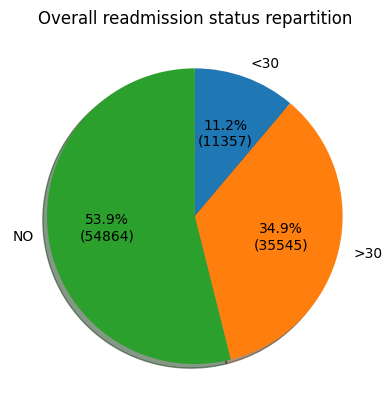

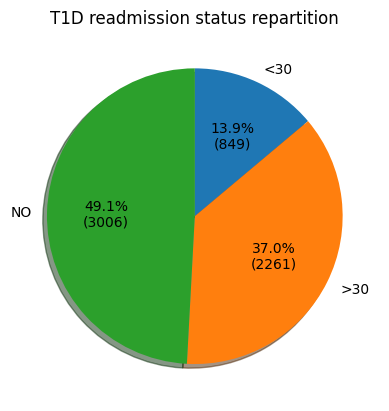

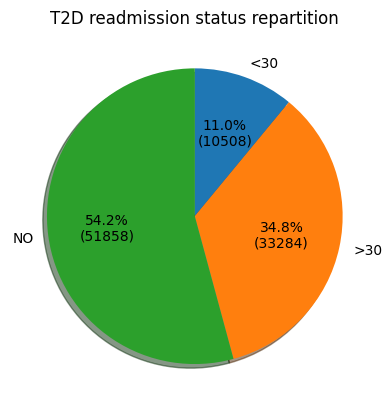

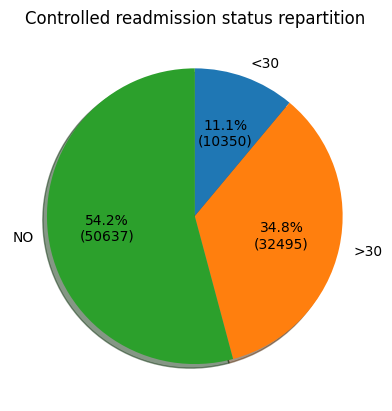

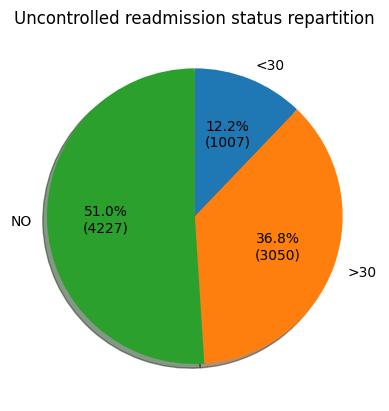

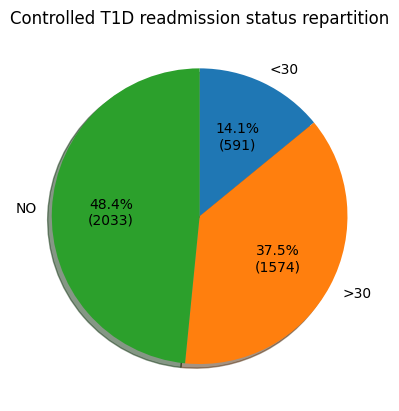

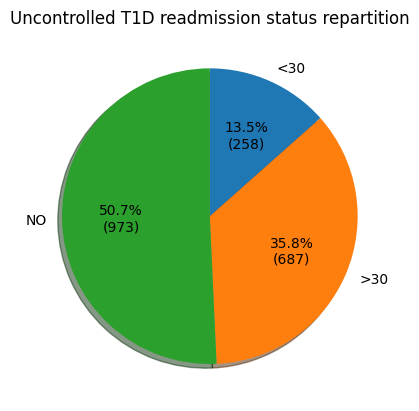

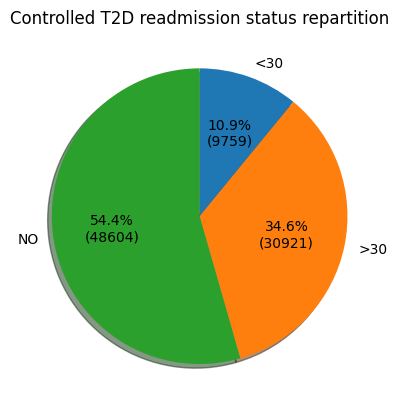

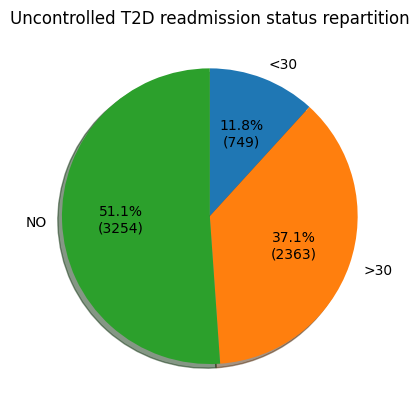

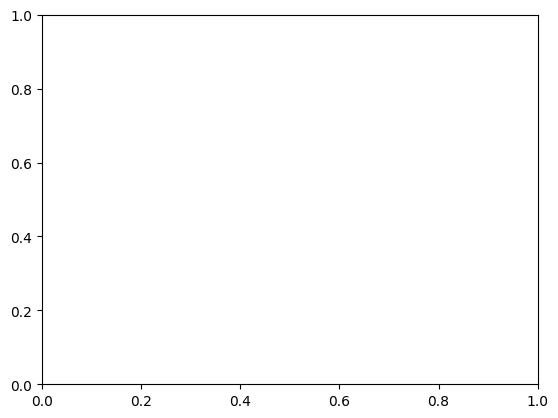

In [19]:
# Overall readmission status repartition
fig, ax = do_pie_chart(data=data)

# per diabetes type readmisison status repartition
for diabetes_name, diabetes_value in [("T1D", 1), ("T2D", 2)]:
    fig, ax = do_pie_chart(data=data.copy()[data.diab_type == diabetes_value], title=f"{diabetes_name} readmission status repartition")

# per control level readmission status repartition
for control_level_name, control_level_value in [("Controlled", "controlled"), ("Uncontrolled", "uncontrolled")]:
    fig, ax = do_pie_chart(data=data.copy()[data.diab_control == control_level_value], title=f"{control_level_name} readmission status repartition")

# per diabetes type and control level readmission status repartition
for diabetes_name, diabetes_value in [("T1D", 1), ("T2D", 2)]:
    for control_level_name, control_level_value in [("Controlled", "controlled"), ("Uncontrolled", "uncontrolled")]:
        fig, ax = do_pie_chart(data=data.copy()[(data.diab_control == control_level_value) & (data.diab_type == diabetes_value)], title=f"{control_level_name} {diabetes_name} readmission status repartition")